In [1]:
import os
import pickle
import plotly
import random
import re
import scipy
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lime import lime_text
from lime.lime_text import LimeTextExplainer

# import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

from sklearn.pipeline import make_pipeline

from termcolor import colored

from tqdm.auto import tqdm, trange

In [315]:
# Create the data object
def make_plot(pred_df, suicide_only = False):
    
    # Create a layout with two yaxes
    layout = go.Layout(height=600, width=1000, font=dict(size=18),
                       title='Prediction of Suicide Risk Assessment',
                       xaxis=dict(title='Conversation Segment'),
                       yaxis=dict(title='Prediction Probability'),
                       )
    
    desire = go.Scatter(x=pred_df.index,
                        y=pred_df['desire'],
                        line=go.scatter.Line(color='green', width = 0.8),
                        opacity=0.8,
                        name='Desire',
                        text=[f"Desire: {x}" for x in pred_df['desire_exp']])

    intent = go.Scatter(x=pred_df.index,
                        y=pred_df['intent'],
                        line=dict(color='blue', width=0.8),
                        opacity=0.8,
                        name='Intent',
                        text=[f'Intent: {x}' for x in pred_df['intent_exp']])

    capability = go.Scatter(x=pred_df.index,
                            y=pred_df['capability'],
                            line=dict(color='purple', width=0.8),
                            opacity=0.8,
                            name='Capability',
                            text=[f'Capability: {x}' for x in pred_df['capability_exp']])

    timeframe = go.Scatter(x=pred_df.index,
                            y=pred_df['timeframe'],
                            line=dict(color='red', width=0.8),
                            opacity=0.8,
                            name = 'Timeframe', 
                            text=[f'Timeframe: {x}' for x in pred_df['timeframe_exp']])

    if not suicide_only:
        anxiety = go.Scatter(x=pred_df.index,
                                y=pred_df['anxiety'],
                                line=dict(color='orange', width=0.8),
                                opacity=0.8,
                                name = 'Anxiety', 
                                text=[f'Anxiety: {x}' for x in pred_df['anxiety_exp']])

        substance = go.Scatter(x=pred_df.index,
                                y=pred_df['substance'],
                                line=dict(color='maroon', width=0.8),
                                opacity=0.8,
                                name = 'Substance', 
                                text=[f'Substance: {x}' for x in pred_df['substance_exp']])

        depressed = go.Scatter(x=pred_df.index,
                                y=pred_df['depressed'],
                                line=dict(color='pink', width=0.8),
                                opacity=0.8,
                                name = 'Depressed', 
                                text=[f'Depressed: {x}' for x in pred_df['depressed_exp']])

        self_harm = go.Scatter(x=pred_df.index,
                                y=pred_df['self_harm'],
                                line=dict(color='cyan', width=0.8),
                                opacity=0.8,
                                name = 'Self harm', 
                                text=[f'Self harm: {x}' for x in pred_df['self_harm_exp']])

        helpful = go.Scatter(x=pred_df.index,
                                y=pred_df['helpful'],
                                line=dict(color='magenta', width=0.8),
                                opacity=0.8,
                                name = 'Helpful', 
                                text=[f'Helpful: {x}' for x in pred_df['helpful_exp']])

        fig = go.Figure(data=[desire, intent, capability, timeframe, 
                              anxiety, depressed, self_harm, substance, 
                              helpful
                             ], 
                        layout=layout)
    else:
        fig = go.Figure(data=[desire, intent, capability, timeframe], 
                        layout=layout)

    ## adding a line y=0.5 for the threshold 
    fig.add_shape(type='line', 
                 x0=1, 
                 x1=5, 
                 y0=0.5, 
                 y1=0.5)
    fig.update_xaxes(dtick=1)
    iplot(fig)
    return

In [271]:
import re

def get_exps(sample, short=False):

    new_df = pd.DataFrame()
    
    max_range = 8 if short else len(sample.columns)

    for i in range(0, max_range, 2):
        column = sample.columns[i+1]
        new_df[column] = sample[column].apply(lambda x: list(set(re.findall(r'(?!br)(?!r)[a-zA-Z0-9][a-zA-Z0-9]*:', x))))
        new_df[column] = new_df[column].apply(lambda x: re.findall(r'[a-zA-Z0-9][a-zA-Z0-9]*', "".join(x)))
    
    final_df = pd.DataFrame(columns=['exp', 'seg', 'label'])    
    max_range /= 2
    adj = -0.10 if short else -0.20

    for col in range(int(max_range)):
        for index in new_df.index:
            for word in new_df.loc[index, new_df.columns[col]]:
                final_df = final_df.append({'exp': word, 
                                            'seg': index + adj,
                                            'label': col}, 
                                           ignore_index=True)
        adj += 0.05
        
    return final_df

In [319]:
def exp_plot(sample, save_as = None):
    plt.rcParams["figure.figsize"] = (8, 5)
    sns.scatterplot(data=sample, x='seg', y='exp', hue="label", legend='full', palette='deep')
    plt.xticks([0, 1, 2, 3, 4, 5, 6], [0, 1, 2, 3, 4, 5, 6])
    plt.xlabel("Conversation Segment")
    plt.ylabel("Explanation")
    new_labels = ['desire', 'intent', 'capability', 'timeframe', 'substance use', 'depression', 'self harm', 'anxiety', 'helpful']
    for t, l in zip(plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.).get_texts(), new_labels): 
        t.set_text(l)
    if save_as != None:
        plt.tight_layout()
        plt.savefig(save_as)
    plt.show()

## Conversation 3 plots

In [29]:
text = pickle.load(open("saved/text_samples/sample7.pickle", "rb"))
text

In [287]:
conv3 = pickle.load(open("saved/bb_exps/sample7_exp.pickle", "rb"))

In [288]:
conv3_exps = get_exps(conv3, short=True)

In [289]:
conv3_exps = conv3_exps.query("exp != ['with', 'is', 'to', 'now', 'the', 's', 'a', 'have', 'when', 'its', 'how', 'u', 'what', 'hi', 'no', 'not', 'ambulan']")

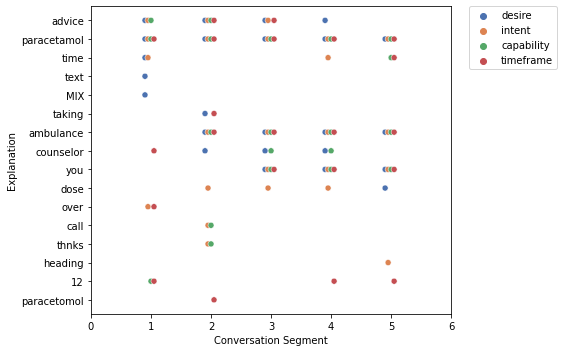

In [325]:
exp_plot(conv3_exps, save_as="figs/convo3_exp.pdf")

In [316]:
make_plot(conv3, suicide_only=True)

## Conversation 2 plots

In [292]:
conv2 = pickle.load(open("saved/bb_exps/sample8_exp.pickle", "rb"))

In [294]:
conv2_exps = get_exps(conv2, short=True)

In [297]:
conv2_exps = conv2_exps.query("exp != ['it', 'when', 'before', 've', 'have', 'hi', 's', 'but', 'this']")

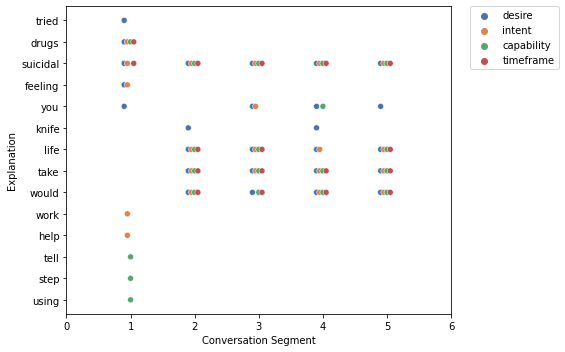

In [322]:
exp_plot(conv2_exps, save_as="figs/convo2_exp.pdf")

In [317]:
make_plot(conv2, suicide_only=True)

## Conversation 1 plots

In [283]:
conv1 = pickle.load(open("saved/bb_exps/sample9_exp.pickle", "rb"))

In [300]:
conv1_exps = get_exps(conv1, short = False)

In [304]:
conv1_exps = conv1_exps.query("exp != ['in', 'and', 'would', 'how', 'have', 'this', 've', 'e', 'to', 'if', 's', 't', 'don', 'm', 'with']")

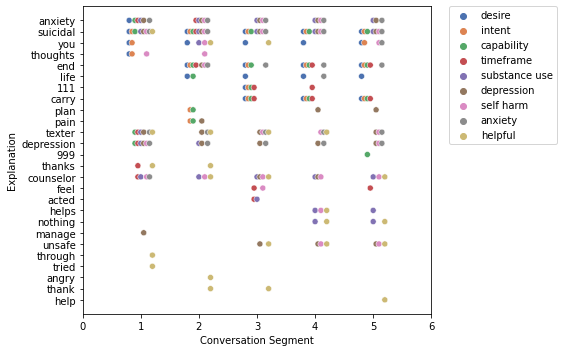

In [323]:
exp_plot(conv1_exps, save_as="figs/convo1_exp.pdf")

In [318]:
make_plot(conv1)